# Solving Eigenvalue Problems with FFNN Models

In this notebook, an FFNN model is employed within the TensorFlow framework to learn the solution to the nonlinear, coupled ODE, presented by Yi et. al in the article from [Computers and Mathematics with Applications 47, 1155 (2004)](https://www.sciencedirect.com/science/article/pii/S0898122104901101), describing the state of a CTRNN model. Given a real symmetric matrix $A$ in the source term, the temporal dynamic described by this ODE has convergence properties to the largest eigenvalue $\lambda$, given that the initial vector $\mathbf{x}_0$ is not orthogonal to the eigenspace of $\lambda$. If $\mathbf{x}_0$ is not orthogonal to the eigenspace of the smallest eigenvalue $\sigma$, replacing $A$ with $-A$ yields the smallest eigenvalue.

The aim is to design a FFNN model suitable for solving this ODE, and check if it succeeds in computing both the largest and smallest eigenvalue for some benchmark $3\times 3$ and $6\times 6$ real symmetric matrices. We will also try choosing $\mathbf{x}_0$ orthogonal to the eigenspace corresponding to the largest eigenvalue, to make the network converge to an eigenvalue different from the largest. This starting point will itself be an eigenvector.

In order to assess the FFNN model, we will compare the result with those from Euler's method for solving the same ODE and Numpy's ``linalg.eig`` which directly computes the eigenvalues of the matrix $A$. 

Unfortunately, we found tensorflow objects (such as tensorflow functions) hard to reuse. There is therefore much repetitive code in the code cells below. This notebook is organized such that each code cell have all the necessary code, except imports, to solve a particular problem. To better distinguish what problem a particular code cell solves, we have added headers that explains the problem at hand.

### Configure notebook

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Import code from src
sys.path.insert(0, '../src/')
from tools import fig_path

tf.keras.backend.set_floatx("float64")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)

## Benchmark Problem 1: Largest Eigenvalue of a 3x3 Matrix 

Step: 1, Loss: 1.2770721346990614
Step: 100, Loss: 0.13565214997579517
Step: 200, Loss: 0.04199647585450187
Step: 300, Loss: 0.023209714150359537
Step: 400, Loss: 0.013092356833334875
Step: 500, Loss: 0.01064056661740722
Step: 600, Loss: 0.003952909384193754
Step: 700, Loss: 0.0019266398724897
Step: 800, Loss: 0.00293280217427406
Step: 900, Loss: 0.00545684178487272
Step: 1000, Loss: 0.0003306854376065401
Step: 1100, Loss: 0.00016569817135423322
Step: 1200, Loss: 0.0003254637215449765
Step: 1300, Loss: 0.0008938604720275068
Step: 1400, Loss: 0.00012325398815160615
Step: 1500, Loss: 0.005208621467687127
Step: 1600, Loss: 0.00011120936926991063
Step: 1700, Loss: 0.0002047675602712933
Step: 1800, Loss: 2.6427126136123678e-05
Step: 1900, Loss: 0.0029463779594214447
Step: 2000, Loss: 3.226287771886442e-05

A = [[3. 2. 4.]
 [2. 0. 2.]
 [4. 2. 3.]]
x0 = [1. 0. 0.]
Eigvals Numpy: [-1.  8. -1.]
Max Eigval Numpy 8.0
Eigvec Numpy: [0.66666667 0.33333333 0.66666667]
Final Rayleigh Quotient Euler 7

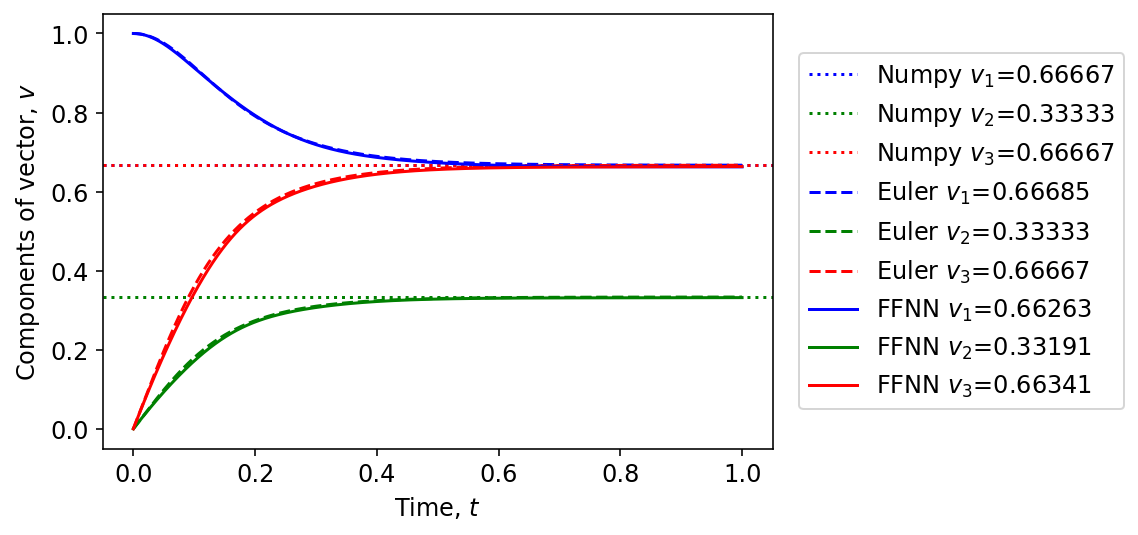

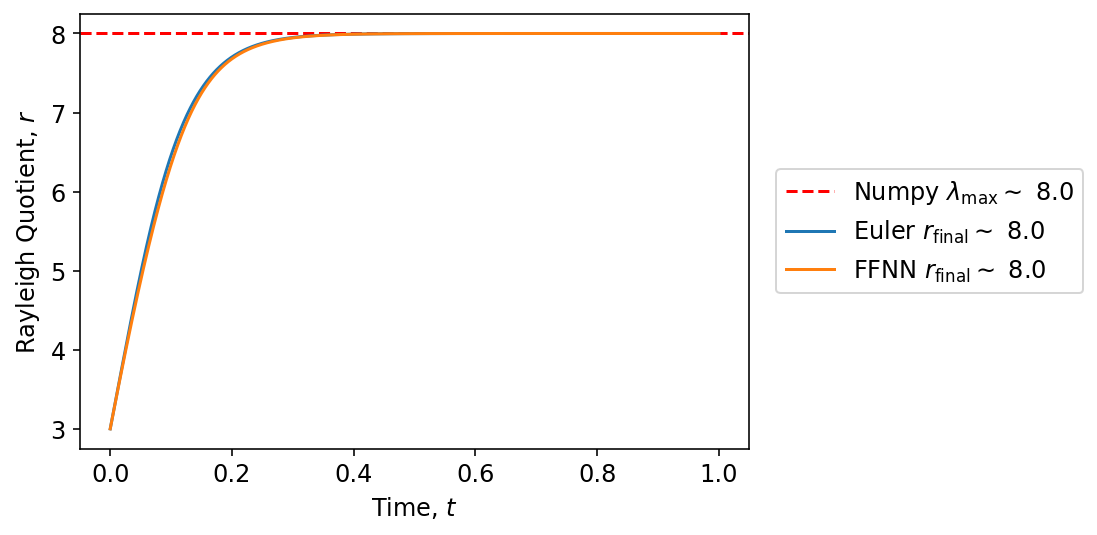

In [2]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time

# Problem formulation for Euler
N = 10000   # number of time points
A = np.array([[3., 2., 4.], [2., 0., 2.], [4., 2., 3.]])
x0 = np.array([1, 0, 0])
x0 = x0 / np.linalg.norm(x0)
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11   # number of time points
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Eigvec Numpy:', w[:,1])
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))
print('Percent Error Euler', 100 * np.abs((np.max(v) - eig_euler[-1]) / np.max(v)))
print('Percent Error FFNN', 100 * np.abs((np.max(v) - eig_nn.numpy()[-1]) / np.max(v)))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_benchrun1.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='center left', bbox_to_anchor=(1.04, 0.5),
           fancybox=True, borderaxespad=0, ncol=1)
fig.savefig(fig_path("eigval_benchrun1.pdf"), bbox_inches='tight')
plt.show()

## Benchmark Problem 2: Smallest Eigenvalue of a 3x3 Matrix 

Step: 1, Loss: 0.11475625842553484
Step: 100, Loss: 0.007679473992883806
Step: 200, Loss: 0.003437857169364238
Step: 300, Loss: 0.0011806430123443871
Step: 400, Loss: 0.00023968403639513673
Step: 500, Loss: 9.616829890006664e-05
Step: 600, Loss: 6.213921229360184e-05
Step: 700, Loss: 4.2926854755923676e-05
Step: 800, Loss: 2.9793738486939048e-05
Step: 900, Loss: 2.074593338577578e-05
Step: 1000, Loss: 1.4603613707477458e-05
Step: 1100, Loss: 1.048566128756934e-05
Step: 1200, Loss: 7.74124104007499e-06
Step: 1300, Loss: 5.905525777359724e-06
Step: 1400, Loss: 4.656018154465253e-06
Step: 1500, Loss: 3.777391991501636e-06
Step: 1600, Loss: 3.1330318073342733e-06
Step: 1700, Loss: 2.640761757599617e-06
Step: 1800, Loss: 2.2528921268120218e-06
Step: 1900, Loss: 1.9415724888211408e-06
Step: 2000, Loss: 1.6894610350215744e-06

A = [[2. 1. 0.]
 [1. 2. 1.]
 [0. 1. 2.]]
x0 = [ 0.81649658 -0.40824829  0.40824829]
Eigvals Numpy: [3.41421356 2.         0.58578644]
Min Eigval Numpy 0.585786437626904

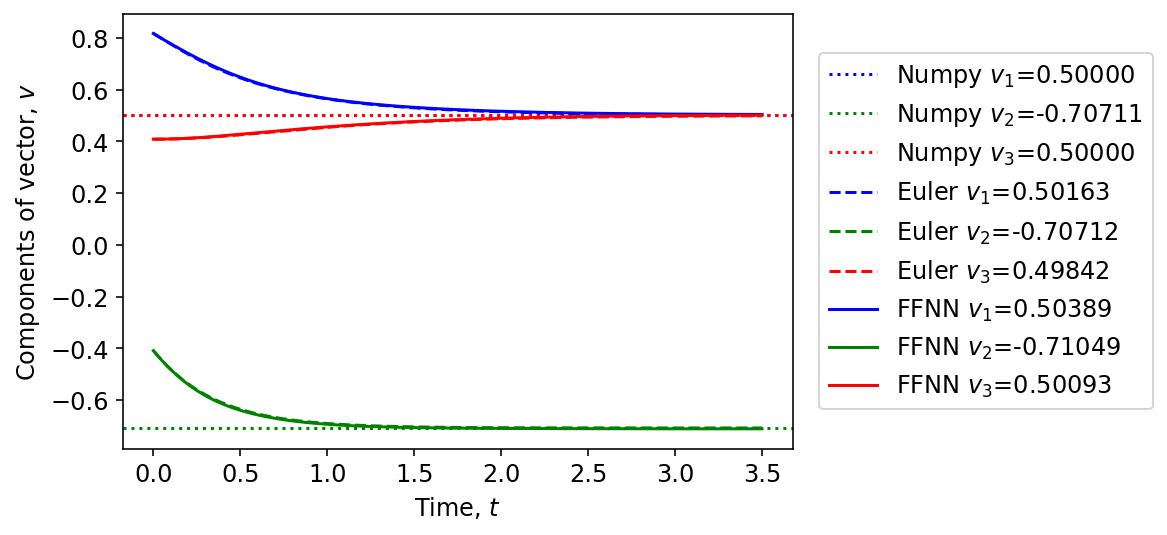

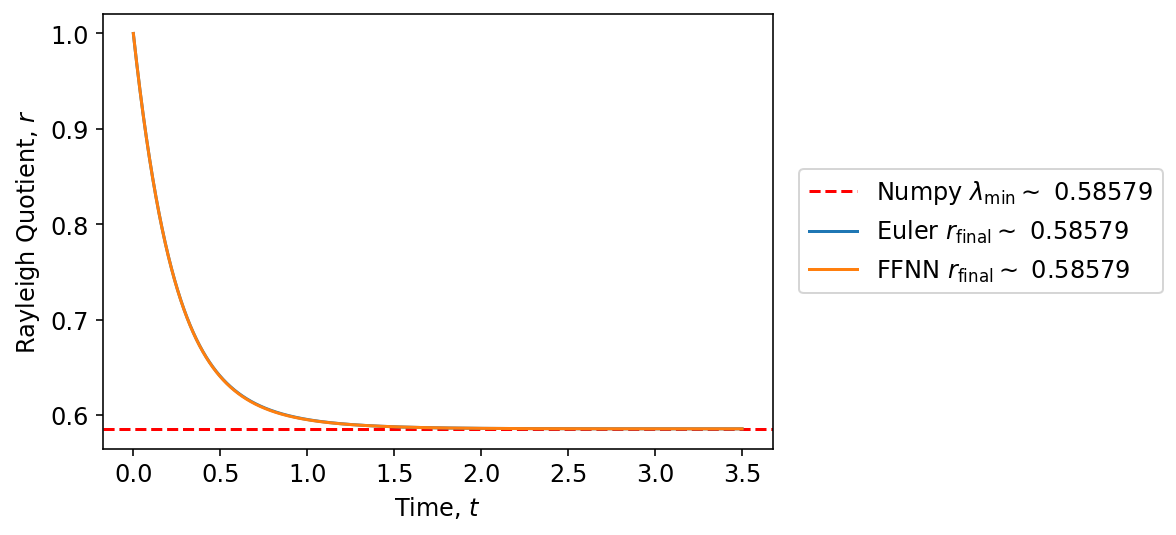

In [3]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 3.5    # Final time

# Problem formulation for Euler
N = 10000   # number of time points
A = np.array([[2., 1., 0.], [1., 2., 1.], [0., 1., 2.]])
x0 = np.array([2, -1, 1])
x0 = x0 / np.linalg.norm(x0)
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11   # number of time points
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, -A_tf, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(-A, x0, T, N)
eig_euler = -eig_euler

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Min Eigval Numpy', np.min(v))
print('Eigvec Numpy:', w[:, 1])
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.min(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.min(v) - eig_nn.numpy()[-1]))
print('Percent Error Euler', 100 * np.abs((np.min(v) - eig_euler[-1]) / np.min(v)))
print('Percent Error FFNN', 100 * np.abs((np.min(v) - eig_nn.numpy()[-1]) / np.min(v)))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(w[0, 2], color='b', ls=':', label=f'Numpy $v_1$={w[0, 2]:.5f}')
ax0.axhline(w[1, 2], color='g', ls=':', label=f'Numpy $v_2$={w[1, 2]:.5f}')
ax0.axhline(w[2, 2], color='r', ls=':', label=f'Numpy $v_3$={w[2, 2]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_benchrun2.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.min(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{min}} \\sim$ " + \
    str(round(np.min(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='center left', bbox_to_anchor=(1.04, 0.5),
           fancybox=True, borderaxespad=0, ncol=1)
fig.savefig(fig_path("eigval_benchrun2.pdf"), bbox_inches='tight')
plt.show()

## Benchmark Problem 3:  Initial Vector Orthogonal to Eigenvector Corresponding to Largest Eigenvalue

Step: 1, Loss: 0.10024895796525007
Step: 100, Loss: 1.5525661867868548e-06
Step: 200, Loss: 1.7499758619600117e-07
Step: 300, Loss: 4.105944272391107e-08
Step: 400, Loss: 8.780811488866676e-09
Step: 500, Loss: 1.7461983193462597e-09
Step: 600, Loss: 3.9041227455944195e-10
Step: 700, Loss: 1.705896143892069e-10
Step: 800, Loss: 1.4155298838436644e-10
Step: 900, Loss: 1.3846034202541467e-10
Step: 1000, Loss: 1.3815394933464844e-10
Step: 1100, Loss: 3.975735720324631e-05
Step: 1200, Loss: 8.492460485589718e-09
Step: 1300, Loss: 1.7503953203223863e-09
Step: 1400, Loss: 6.817015864313487e-10
Step: 1500, Loss: 3.8272760489107604e-10
Step: 1600, Loss: 2.6679339568405763e-10
Step: 1700, Loss: 2.1851966384537572e-10
Step: 1800, Loss: 1.990487884573234e-10
Step: 1900, Loss: 1.9158191479144078e-10
Step: 2000, Loss: 1.88820848233479e-10

A = [[ 3  1 -1]
 [ 1  3 -1]
 [-1 -1  5]]
x0 = [-0.70710678  0.70710678  0.        ]
Eigvals Numpy: [6. 2. 3.]
Final Rayleigh Quotient Euler 2.0000000000000004
Fin

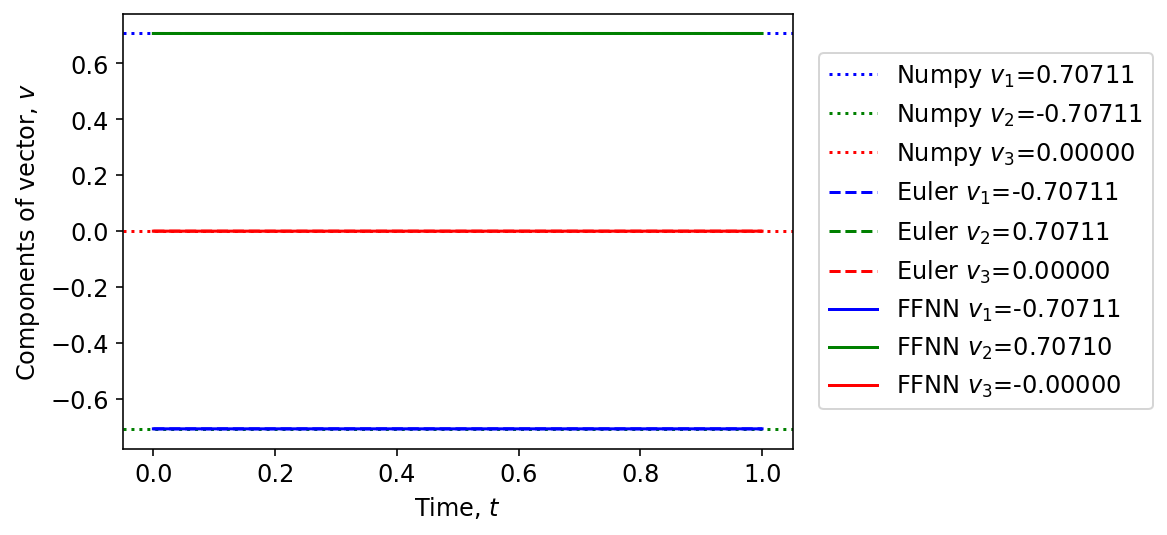

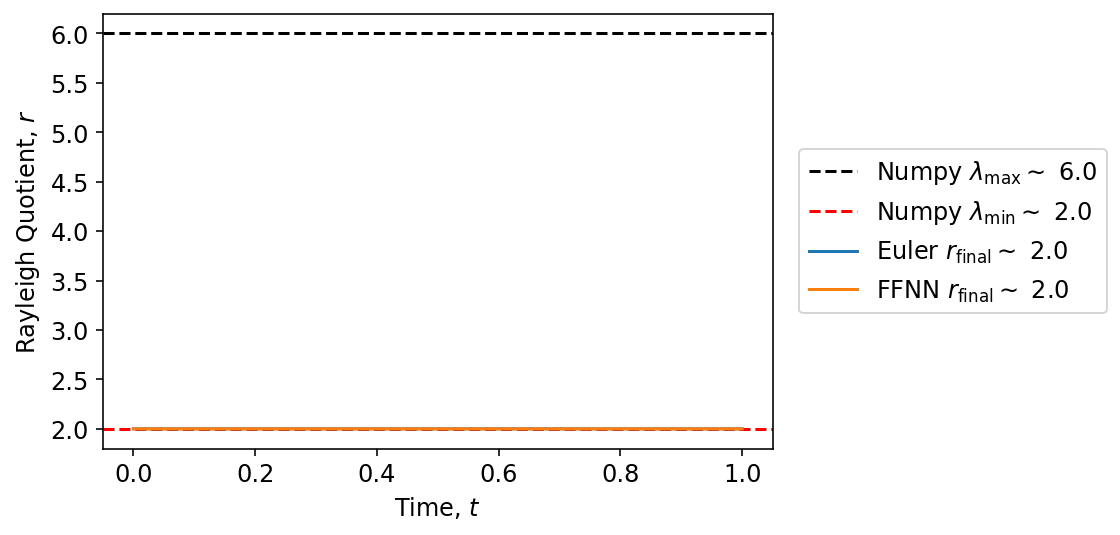

In [4]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time

# Problem formulation for Euler
N = 10000   # number of time points
A = np.array([[3, 1, -1], [1, 3, -1], [-1, -1, 5]])
x0 = np.array([-1, 1, 0])
x0 = x0 / np.linalg.norm(x0)
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11   # number of time points
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, -A_tf, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(-A, x0, T, N)
eig_euler = -eig_euler

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.min(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.min(v) - eig_nn.numpy()[-1]))
print('Percent Error Euler', 100 * np.abs((np.min(v) - eig_euler[-1]) / np.min(v)))
print('Percent Error FFNN', 100 * np.abs((np.min(v) - eig_nn.numpy()[-1]) / np.min(v)))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(-w[0, 1], color='b', ls=':', label=f'Numpy $v_1$={-w[0, 1]:.5f}')
ax0.axhline(-w[1, 1], color='g', ls=':', label=f'Numpy $v_2$={-w[1, 1]:.5f}')
ax0.axhline(-w[2, 1], color='r', ls=':', label=f'Numpy $v_3$={-w[2, 1]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_benchrun3.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='k', ls='--')
ax.axhline(np.min(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy1 = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_numpy2 = "Numpy $\\lambda_{\\mathrm{min}} \\sim$ " + \
    str(round(np.min(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy1, lgd_numpy2, lgd_euler, lgd_nn], loc='center left', bbox_to_anchor=(1.04, 0.5),
           fancybox=True, borderaxespad=0, ncol=1)
fig.savefig(fig_path("eigval_benchrun3.pdf"), bbox_inches='tight')
plt.show()

## Benchmark Problem 4: 6x6 matrix and the effect of number of time points

### a-run: T=10, N=51 (Euler), Nt=5 (FFNN)

Step: 1, Loss: 1.507756897411548
Step: 100, Loss: 0.02870236666116594
Step: 200, Loss: 0.01411281455757312
Step: 300, Loss: 0.00132519492207349
Step: 400, Loss: 0.00034006720987815153
Step: 500, Loss: 0.00017729911367204772
Step: 600, Loss: 0.00011090062574029504
Step: 700, Loss: 7.49243352090656e-05
Step: 800, Loss: 5.3213079775323914e-05
Step: 900, Loss: 3.933152571253237e-05
Step: 1000, Loss: 3.0119015153967827e-05
Step: 1100, Loss: 2.3825109372399656e-05
Step: 1200, Loss: 1.9401506690098905e-05
Step: 1300, Loss: 1.6191289696543963e-05
Step: 1400, Loss: 1.3775280310843091e-05
Step: 1500, Loss: 1.1886031415013231e-05
Step: 1600, Loss: 1.03543760480045e-05
Step: 1700, Loss: 9.074255968851034e-06
Step: 1800, Loss: 7.979326018124641e-06
Step: 1900, Loss: 7.027665376018234e-06
Step: 2000, Loss: 6.192080154447607e-06

A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1.19

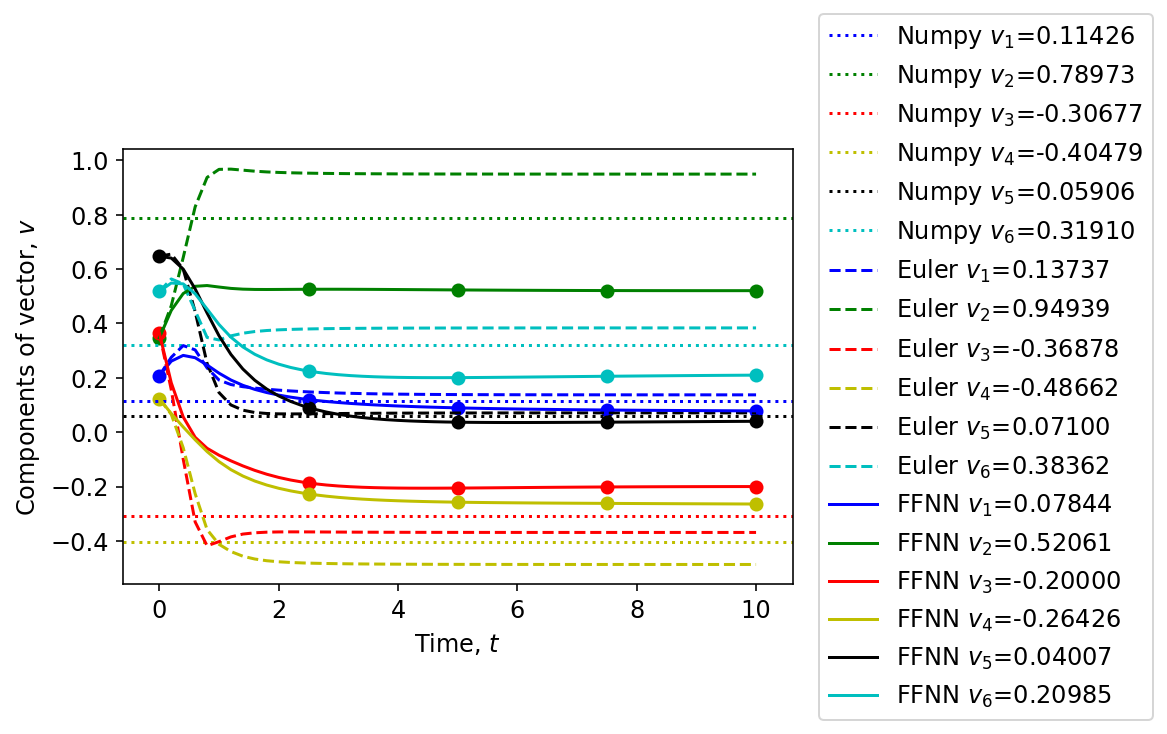

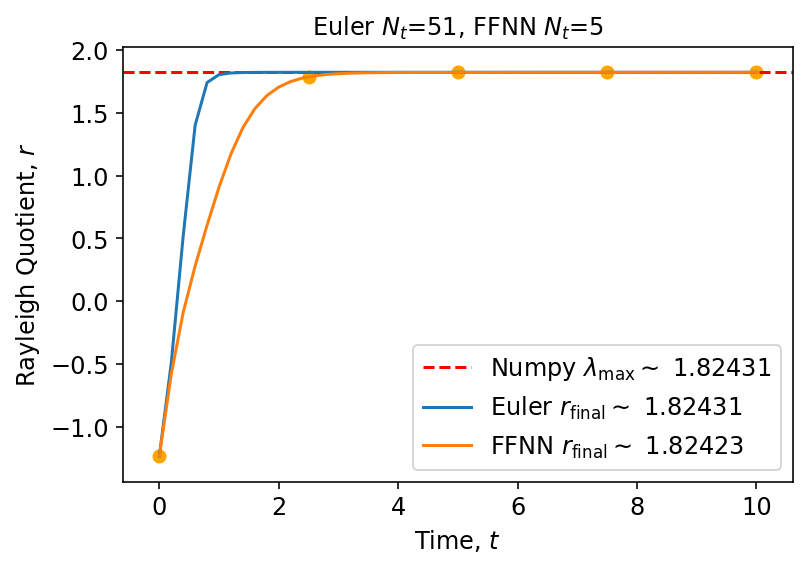

In [5]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6    # Dimension
T = 10    # Final time
N = 51   # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0)

# Problem formulation for tensorflow
Nt = 5   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
g_points = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)
eig_nn_points = ray_quo(A_tf, g_points)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.axhline(w[3, np.argmax(v)], color='y', ls=':', label=f'Numpy $v_4$={w[3, np.argmax(v)]:.5f}')
ax0.axhline(w[4, np.argmax(v)], color='k', ls=':', label=f'Numpy $v_5$={w[4, np.argmax(v)]:.5f}')
ax0.axhline(w[5, np.argmax(v)], color='c', ls=':', label=f'Numpy $v_6$={w[5, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t, x_euler[:, 3], color='y', ls='--', label=f'Euler $v_4$={x_euler[-1, 3]:.5f}')
ax0.plot(t, x_euler[:, 4], color='k', ls='--', label=f'Euler $v_5$={x_euler[-1, 4]:.5f}')
ax0.plot(t, x_euler[:, 5], color='c', ls='--', label=f'Euler $v_6$={x_euler[-1, 5]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.plot(s, g[:, 3], color='y', label=f'FFNN $v_4$={g[-1, 3]:.5f}')
ax0.plot(s, g[:, 4], color='k', label=f'FFNN $v_5$={g[-1, 4]:.5f}')
ax0.plot(s, g[:, 5], color='c', label=f'FFNN $v_6$={g[-1, 5]:.5f}')
ax0.scatter(t_tf, g_points[:, 0], color='b')
ax0.scatter(t_tf, g_points[:, 1], color='g')
ax0.scatter(t_tf, g_points[:, 2], color='r')
ax0.scatter(t_tf, g_points[:, 3], color='y')
ax0.scatter(t_tf, g_points[:, 4], color='k')
ax0.scatter(t_tf, g_points[:, 5], color='c')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_run66a.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.scatter(t_tf, eig_nn_points, color='orange')
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66a.pdf"), bbox_inches='tight')
plt.show()

### b-run: T=10, N=101 (Euler), Nt=11 (FFNN)

Step: 1, Loss: 1.4257049914502256
Step: 100, Loss: 0.019537108364591507
Step: 200, Loss: 0.015339344190948566
Step: 300, Loss: 0.01306799113939156
Step: 400, Loss: 0.008995917659635862
Step: 500, Loss: 0.004412657247088978
Step: 600, Loss: 0.0017075920610810534
Step: 700, Loss: 0.0007461702780734097
Step: 800, Loss: 0.0004204641977531869
Step: 900, Loss: 0.0002770856241377926
Step: 1000, Loss: 0.00019469650436686997
Step: 1100, Loss: 0.0001395588617908817
Step: 1200, Loss: 0.00010017693685901749
Step: 1300, Loss: 7.189624856097134e-05
Step: 1400, Loss: 5.2243118196596175e-05
Step: 1500, Loss: 3.9182698376147547e-05
Step: 1600, Loss: 3.071004255994297e-05
Step: 1700, Loss: 2.5098068795367477e-05
Step: 1800, Loss: 2.1145698221728588e-05
Step: 1900, Loss: 1.8154866571660346e-05
Step: 2000, Loss: 1.5760144698803583e-05

A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1.1

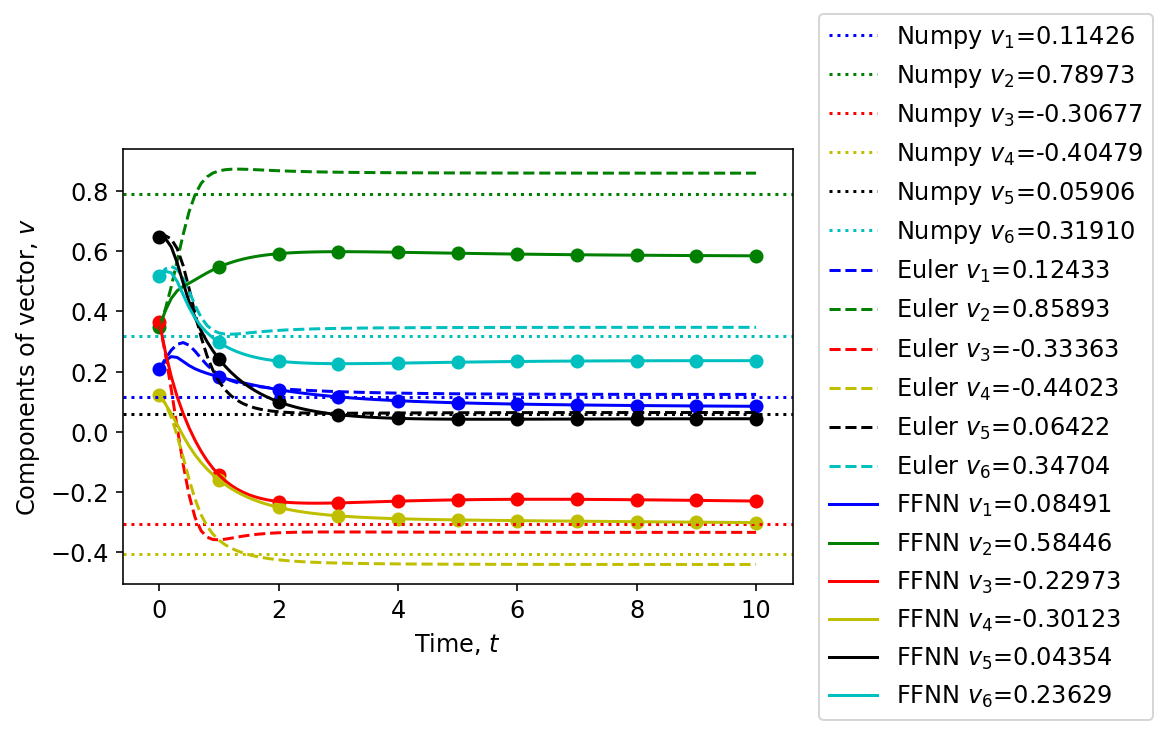

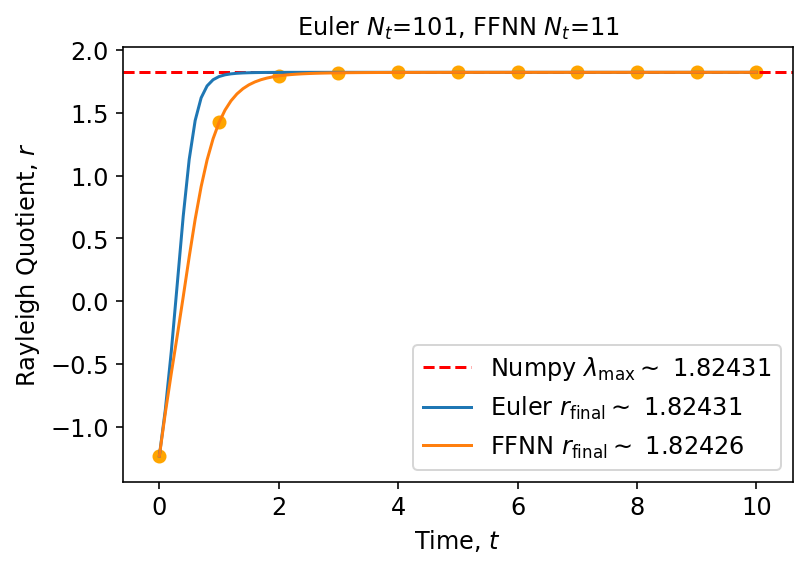

In [6]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6    # Dimension
T = 10    # Final time
N = 101   # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0)

# Problem formulation for tensorflow
Nt = 11   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
g_points = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)
eig_nn_points = ray_quo(A_tf, g_points)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.axhline(w[3, np.argmax(v)], color='y', ls=':', label=f'Numpy $v_4$={w[3, np.argmax(v)]:.5f}')
ax0.axhline(w[4, np.argmax(v)], color='k', ls=':', label=f'Numpy $v_5$={w[4, np.argmax(v)]:.5f}')
ax0.axhline(w[5, np.argmax(v)], color='c', ls=':', label=f'Numpy $v_6$={w[5, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t, x_euler[:, 3], color='y', ls='--', label=f'Euler $v_4$={x_euler[-1, 3]:.5f}')
ax0.plot(t, x_euler[:, 4], color='k', ls='--', label=f'Euler $v_5$={x_euler[-1, 4]:.5f}')
ax0.plot(t, x_euler[:, 5], color='c', ls='--', label=f'Euler $v_6$={x_euler[-1, 5]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.plot(s, g[:, 3], color='y', label=f'FFNN $v_4$={g[-1, 3]:.5f}')
ax0.plot(s, g[:, 4], color='k', label=f'FFNN $v_5$={g[-1, 4]:.5f}')
ax0.plot(s, g[:, 5], color='c', label=f'FFNN $v_6$={g[-1, 5]:.5f}')
ax0.scatter(t_tf, g_points[:, 0], color='b')
ax0.scatter(t_tf, g_points[:, 1], color='g')
ax0.scatter(t_tf, g_points[:, 2], color='r')
ax0.scatter(t_tf, g_points[:, 3], color='y')
ax0.scatter(t_tf, g_points[:, 4], color='k')
ax0.scatter(t_tf, g_points[:, 5], color='c')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_run66b.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.scatter(t_tf, eig_nn_points, color='orange')
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66b.pdf"), bbox_inches='tight')
plt.show()

### c-run: T=10, N=501 (Euler), Nt=51 (FFNN)

Step: 1, Loss: 1.3906203496223715
Step: 100, Loss: 0.010730036465785292
Step: 200, Loss: 0.006746229087721715
Step: 300, Loss: 0.006290440481653594
Step: 400, Loss: 0.006022745538174261
Step: 500, Loss: 0.005640676667918491
Step: 600, Loss: 0.005063054334056205
Step: 700, Loss: 0.004314002001306838
Step: 800, Loss: 0.0036430656673684127
Step: 900, Loss: 0.003181771035841183
Step: 1000, Loss: 0.00283695355532121
Step: 1100, Loss: 0.002518678562935474
Step: 1200, Loss: 0.0022003045606330193
Step: 1300, Loss: 0.001884403991953506
Step: 1400, Loss: 0.0015832394081289254
Step: 1500, Loss: 0.0013052928167794275
Step: 1600, Loss: 0.001056257111535443
Step: 1700, Loss: 0.0008419447851497142
Step: 1800, Loss: 0.0006654319190755761
Step: 1900, Loss: 0.0005248485434488058
Step: 2000, Loss: 0.0004145570698620125

A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1.19137732 -1.7249

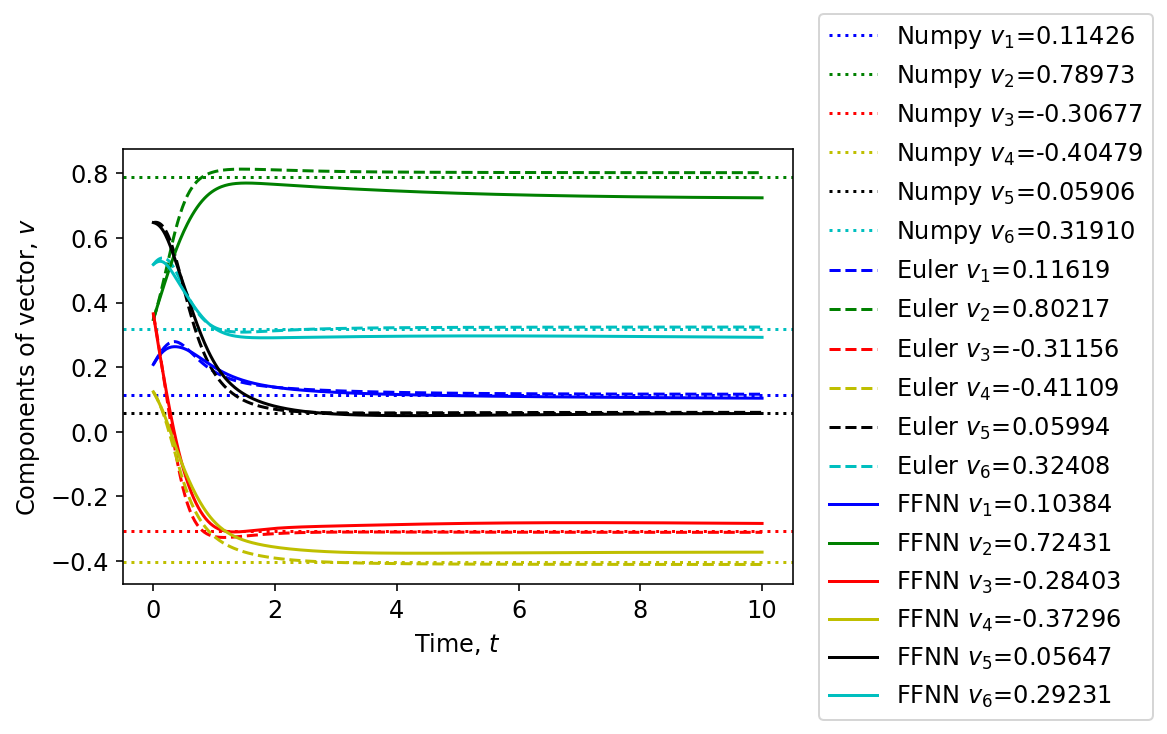

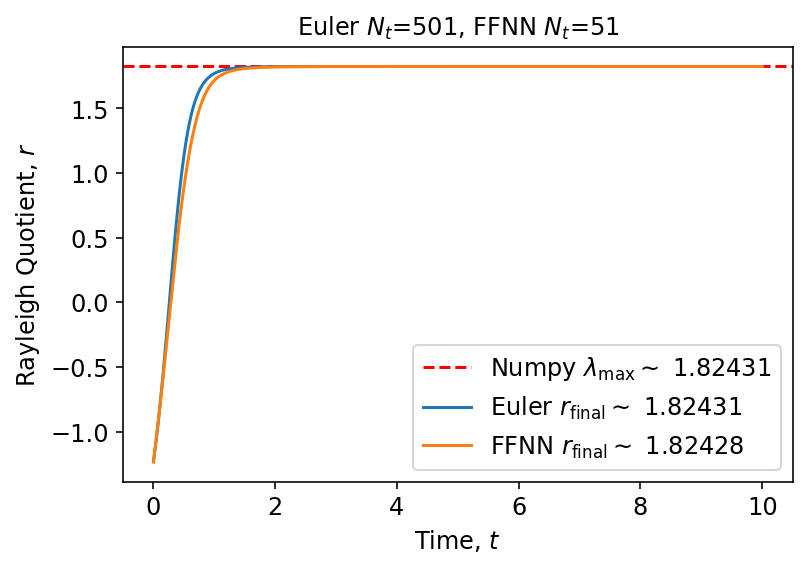

In [7]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6    # Dimension
T = 10    # Final time
N = 501   # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0)

# Problem formulation for tensorflow
Nt = 51   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
g_points = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)
eig_nn_points = ray_quo(A_tf, g_points)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.axhline(w[3, np.argmax(v)], color='y', ls=':', label=f'Numpy $v_4$={w[3, np.argmax(v)]:.5f}')
ax0.axhline(w[4, np.argmax(v)], color='k', ls=':', label=f'Numpy $v_5$={w[4, np.argmax(v)]:.5f}')
ax0.axhline(w[5, np.argmax(v)], color='c', ls=':', label=f'Numpy $v_6$={w[5, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t, x_euler[:, 3], color='y', ls='--', label=f'Euler $v_4$={x_euler[-1, 3]:.5f}')
ax0.plot(t, x_euler[:, 4], color='k', ls='--', label=f'Euler $v_5$={x_euler[-1, 4]:.5f}')
ax0.plot(t, x_euler[:, 5], color='c', ls='--', label=f'Euler $v_6$={x_euler[-1, 5]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.plot(s, g[:, 3], color='y', label=f'FFNN $v_4$={g[-1, 3]:.5f}')
ax0.plot(s, g[:, 4], color='k', label=f'FFNN $v_5$={g[-1, 4]:.5f}')
ax0.plot(s, g[:, 5], color='c', label=f'FFNN $v_6$={g[-1, 5]:.5f}')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_run66c.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66c.pdf"), bbox_inches='tight')
plt.show()

### d-run: T=10, N=1001 (Euler), Nt=101 (FFNN)

Step: 1, Loss: 1.3878186241159736
Step: 100, Loss: 0.009623530588994676
Step: 200, Loss: 0.005803311458425382
Step: 300, Loss: 0.005327170969956886
Step: 400, Loss: 0.005119881973898079
Step: 500, Loss: 0.004848246685806769
Step: 600, Loss: 0.004444425542282934
Step: 700, Loss: 0.003868116037728766
Step: 800, Loss: 0.0032513566677788218
Step: 900, Loss: 0.002790775149901312
Step: 1000, Loss: 0.0024853981176692756
Step: 1100, Loss: 0.002240469857148991
Step: 1200, Loss: 0.002009554219131044
Step: 1300, Loss: 0.0017814415170680407
Step: 1400, Loss: 0.0015582181239297904
Step: 1500, Loss: 0.0013443117640917687
Step: 1600, Loss: 0.0011432760053015712
Step: 1700, Loss: 0.0009587888650219622
Step: 1800, Loss: 0.0007947270834195577
Step: 1900, Loss: 0.0006537368457031287
Step: 2000, Loss: 0.0005361216729334453

A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1.19137732 -1.7

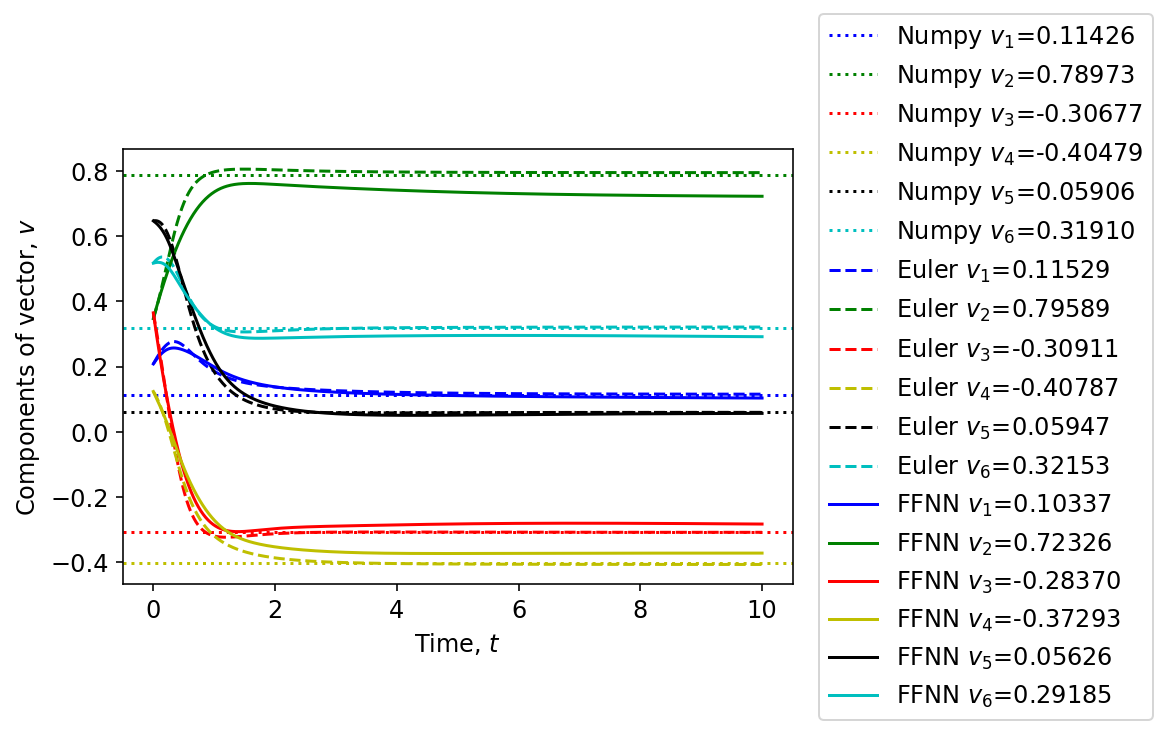

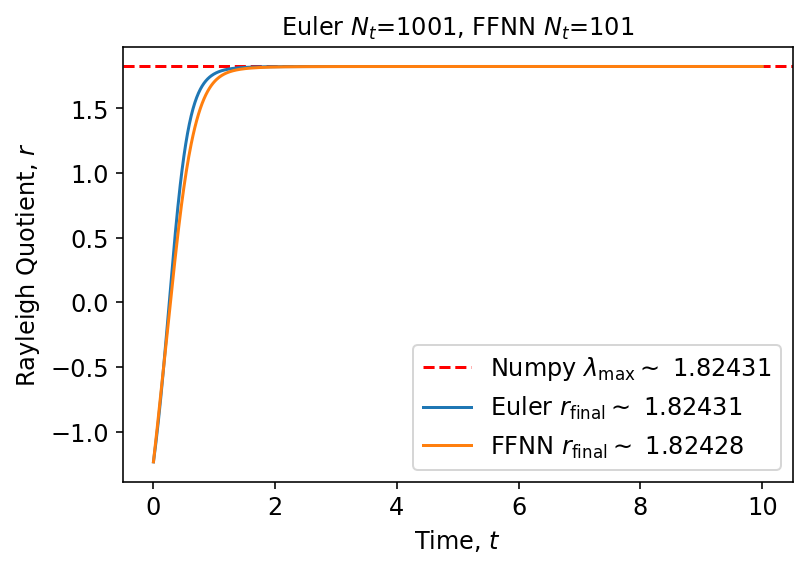

In [8]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6     # Dimension
T = 10    # Final time
N = 1001  # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0)

# Problem formulation for tensorflow
Nt = 101   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
g_points = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)
eig_nn_points = ray_quo(A_tf, g_points)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.axhline(w[3, np.argmax(v)], color='y', ls=':', label=f'Numpy $v_4$={w[3, np.argmax(v)]:.5f}')
ax0.axhline(w[4, np.argmax(v)], color='k', ls=':', label=f'Numpy $v_5$={w[4, np.argmax(v)]:.5f}')
ax0.axhline(w[5, np.argmax(v)], color='c', ls=':', label=f'Numpy $v_6$={w[5, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t, x_euler[:, 3], color='y', ls='--', label=f'Euler $v_4$={x_euler[-1, 3]:.5f}')
ax0.plot(t, x_euler[:, 4], color='k', ls='--', label=f'Euler $v_5$={x_euler[-1, 4]:.5f}')
ax0.plot(t, x_euler[:, 5], color='c', ls='--', label=f'Euler $v_6$={x_euler[-1, 5]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.plot(s, g[:, 3], color='y', label=f'FFNN $v_4$={g[-1, 3]:.5f}')
ax0.plot(s, g[:, 4], color='k', label=f'FFNN $v_5$={g[-1, 4]:.5f}')
ax0.plot(s, g[:, 5], color='c', label=f'FFNN $v_6$={g[-1, 5]:.5f}')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_run66d.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66d.pdf"), bbox_inches='tight')
plt.show()

## Final test: see if observations hold for another random 6x6 matrix

Step: 1, Loss: 0.17427765412336127
Step: 100, Loss: 0.014401074667265869
Step: 200, Loss: 0.0009669162016809021
Step: 300, Loss: 0.00027700748515531887
Step: 400, Loss: 0.00010447777332924206
Step: 500, Loss: 3.7648158765241225e-05
Step: 600, Loss: 5.522014636410218e-05
Step: 700, Loss: 1.5475279985917623e-05
Step: 800, Loss: 0.0005357679059268448
Step: 900, Loss: 3.323831517372546e-05
Step: 1000, Loss: 0.000565341577747126
Step: 1100, Loss: 1.6728107731970056e-05
Step: 1200, Loss: 2.4293774913590916e-05
Step: 1300, Loss: 0.00015413910186365084
Step: 1400, Loss: 1.555159527039179e-05
Step: 1500, Loss: 7.071768040872549e-05
Step: 1600, Loss: 8.635671069280744e-06
Step: 1700, Loss: 2.6302844282573114e-05
Step: 1800, Loss: 3.632398269715272e-05
Step: 1900, Loss: 0.00017195847886901358
Step: 2000, Loss: 1.9820053405241265e-05

A = [[ 0.25739993 -0.20514642 -1.02358291 -0.79087729  0.45625895 -0.91044408]
 [-0.20514642  2.01019925  0.20038802 -0.66441622  0.26887196  0.63158454]
 [-1.023582

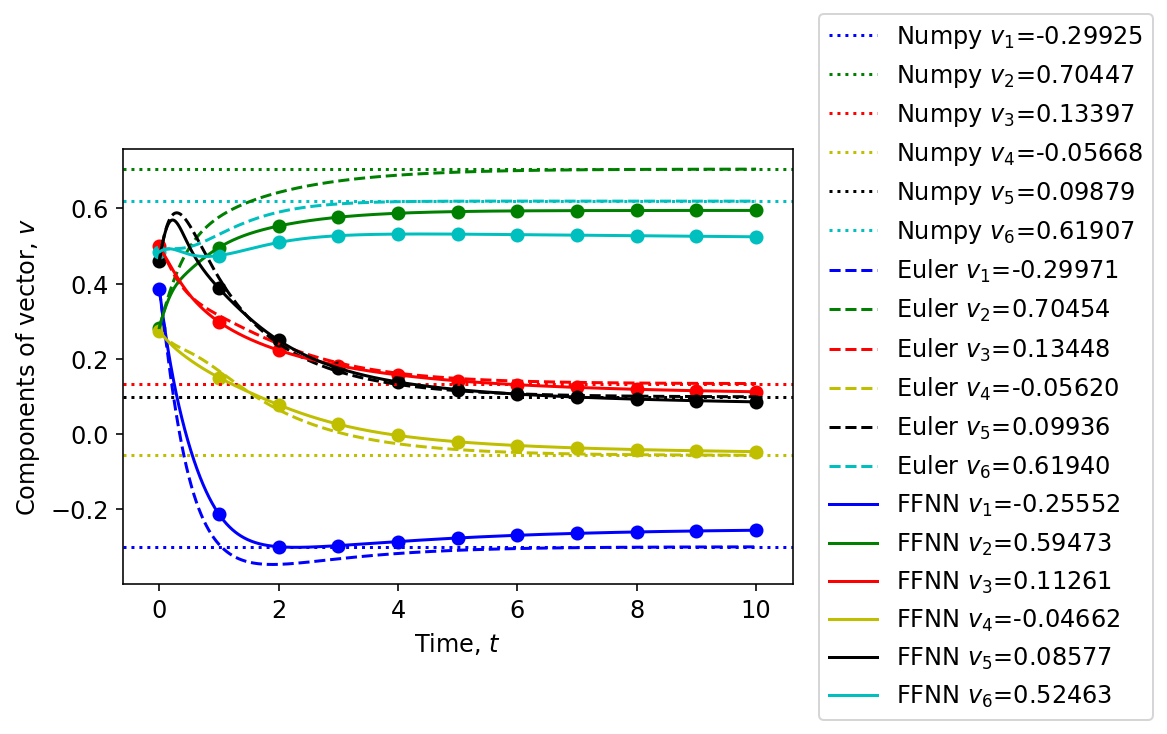

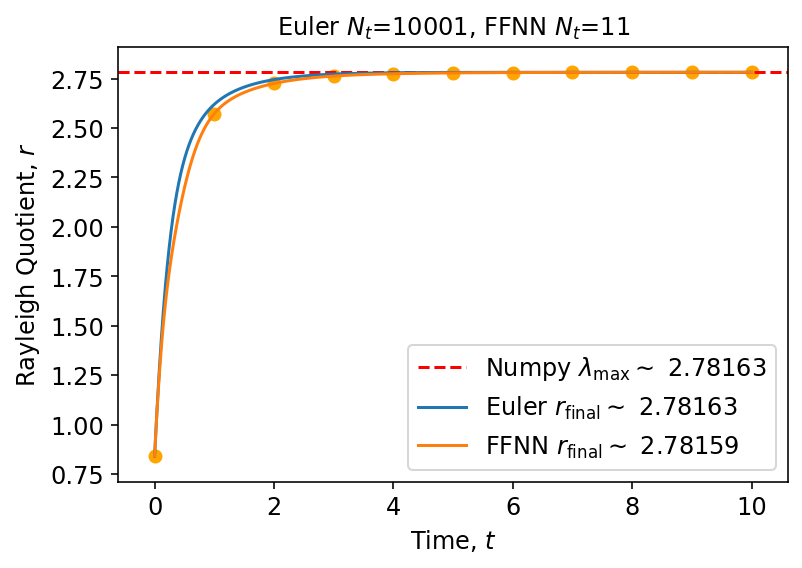

In [9]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(43)
tf.random.set_seed(43)
n = 6     # Dimension
T = 10    # Final time
N = 10001  # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0)

# Problem formulation for tensorflow
Nt = 11   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
g_points = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)
eig_nn_points = ray_quo(A_tf, g_points)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

fig0, ax0 = plt.subplots()
ax0.axhline(-w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={-w[0, np.argmax(v)]:.5f}')
ax0.axhline(-w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={-w[1, np.argmax(v)]:.5f}')
ax0.axhline(-w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={-w[2, np.argmax(v)]:.5f}')
ax0.axhline(-w[3, np.argmax(v)], color='y', ls=':', label=f'Numpy $v_4$={-w[3, np.argmax(v)]:.5f}')
ax0.axhline(-w[4, np.argmax(v)], color='k', ls=':', label=f'Numpy $v_5$={-w[4, np.argmax(v)]:.5f}')
ax0.axhline(-w[5, np.argmax(v)], color='c', ls=':', label=f'Numpy $v_6$={-w[5, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t, x_euler[:, 3], color='y', ls='--', label=f'Euler $v_4$={x_euler[-1, 3]:.5f}')
ax0.plot(t, x_euler[:, 4], color='k', ls='--', label=f'Euler $v_5$={x_euler[-1, 4]:.5f}')
ax0.plot(t, x_euler[:, 5], color='c', ls='--', label=f'Euler $v_6$={x_euler[-1, 5]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.plot(s, g[:, 3], color='y', label=f'FFNN $v_4$={g[-1, 3]:.5f}')
ax0.plot(s, g[:, 4], color='k', label=f'FFNN $v_5$={g[-1, 4]:.5f}')
ax0.plot(s, g[:, 5], color='c', label=f'FFNN $v_6$={g[-1, 5]:.5f}')
ax0.scatter(t_tf, g_points[:, 0], color='b')
ax0.scatter(t_tf, g_points[:, 1], color='g')
ax0.scatter(t_tf, g_points[:, 2], color='r')
ax0.scatter(t_tf, g_points[:, 3], color='y')
ax0.scatter(t_tf, g_points[:, 4], color='k')
ax0.scatter(t_tf, g_points[:, 5], color='c')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_final1.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.scatter(t_tf, eig_nn_points, color='orange')
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_final1.pdf"), bbox_inches='tight')
plt.show()